<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/220127_ji_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ttach

## 성능
F1-score : 0.92

여러 모델 돌려보기

옵티마이저 바꿔보기 등등

In [2]:
!nvidia-smi
# k80 -> T4 -> P100

Thu Jan 27 04:27:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 사용 패키지

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import ttach as tta
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import json
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!unzip /content/drive/MyDrive/data/LG/train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

In [10]:
# !zip -FFv /content/drive/MyDrive/LG/test.zip --out test2.zip

In [11]:
!unzip /content/drive/MyDrive/data/LG/test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/65823/65823.csv    
  inflating: test/65823/65823.jpg    
   creating: test/65824/
  inflating: test/65824/65824.jpg    
  inflating: test/65824/65824.csv    
   creating: test/65825/
  inflating: test/65825/65825.csv    
  inflating: test/65825/65825.jpg    
   creating: test/65827/
  inflating: test/65827/65827.jpg    
  inflating: test/65827/65827.csv    
   creating: test/65828/
  inflating: test/65828/65828.jpg    
  inflating: test/65828/65828.csv    
   creating: test/65829/
  inflating: test/65829/65829.jpg    
  inflating: test/65829/65829.csv    
   creating: test/65830/
  inflating: test/65830/65830.jpg    
  inflating: test/65830/65830.csv    
   creating: test/65831/
  inflating: test/65831/65831.jpg    
  inflating: test/65831/65831.csv    
   creating: test/65832/
  inflating: test/65832/65832.jpg    
  inflating: test/65832/65832.csv    
   creating: test/65833/
  inflating: test/65833/65833.jpg    
  inflating: test

# 데이터 살펴보기

In [40]:
sample = glob('/content/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [41]:
from datetime import datetime, timedelta

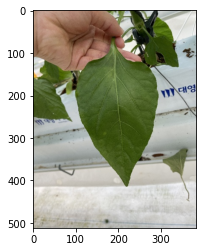

In [42]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
# json
sample_json

{'annotations': {'area': 3,
  'bbox': [{'h': 308.0422867063492,
    'w': 198.38594370039684,
    'x': 97.93409753224206,
    'y': 107.98223586309524}],
  'crop': 3,
  'disease': 'b6',
  'grow': 13,
  'part': [{'h': 189.17815290178572,
    'id': 0,
    'w': 144.8133525545635,
    'x': 148.9954582093254,
    'y': 107.98222036210318},
   {'h': 126.39781746031746,
    'id': 1,
    'w': 89.56665426587301,
    'x': 130.57987661210316,
    'y': 287.115482390873}],
  'risk': 1},
 'description': {'date': '20211103',
  'height': 512,
  'image': '32295.jpg',
  'region': 0,
  'task': 2,
  'time': '1745',
  'width': 384}}

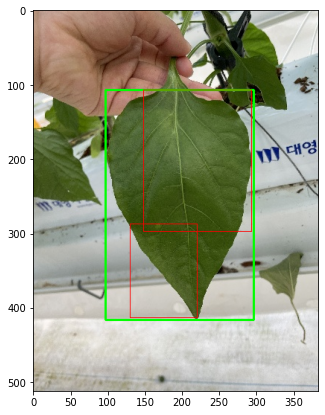

In [44]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [45]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [01:19<00:00, 72.48it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

## CustomDataset 제작

In [46]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [47]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [48]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [49]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)
            df['측정시각'] = pd.to_datetime(df['측정시각'])
            df = df.sort_values(by='측정시각')
            df = df[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'

            # augmentation = random.randint(0,2)
            # if augmentation==1:
            #     img = img[::-1].copy()
            # elif augmentation==2:
            #     img = img[:,::-1].copy()
            # img = transforms.ToTensor()(img)
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [50]:
device = torch.device("cuda:0")
batch_size = 8
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 20
k_folds = 5
vision_pretrain = True
save_path = '/content/drive/MyDrive/data/LG/best_model.pt'

# 데이터셋 구성

In [51]:
train = sorted(glob('/content/train/*'))
test = sorted(glob('/content/test/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/data/LG/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [52]:
train_transforms = A.Compose([
A.Normalize(),
A.HorizontalFlip(),
A.RandomRotate90(p=0.5),
A.VerticalFlip(p=0.5),
ToTensor()
])

In [53]:
train_dataset = CustomDataset(train, train_transforms)
val_dataset = CustomDataset(val)

# test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# 모델

## 이미지 분류 모델 : efficientnet_b7 -> b4 -> b2

In [54]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.efficientnet_b2(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [55]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [56]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [57]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

# 학습

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

# optimizer = torch.optim.SGD(model.parameters(), 
#                          lr = learning_rate,
#                          momentum=0.9,
#                          weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [59]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [60]:
import random
import torchvision.transforms as transforms

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []
      
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  train_dataloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, sampler=train_subsampler, num_workers=2)
  val_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, sampler=test_subsampler, num_workers=2)
  
  for epoch in range(epochs):
      total_loss, total_val_loss = 0, 0
      total_acc, total_val_acc = 0, 0
      
      tqdm_dataset = tqdm(enumerate(train_dataloader))
      training = True
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_loss += batch_loss
          total_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
              'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
          })
      loss_plot.append(total_loss/(batch+1))
      metric_plot.append(total_acc/(batch+1))
      
      tqdm_dataset = tqdm(enumerate(val_dataloader))
      training = False
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_val_loss += batch_loss
          total_val_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Val Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
              'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
          })
      val_loss_plot.append(total_val_loss/(batch+1))
      val_metric_plot.append(total_val_acc/(batch+1))
      scheduler.step()

      if np.max(val_metric_plot) == val_metric_plot[-1]:
          torch.save(model.state_dict(), save_path)

      

## 적정 에포크 8회인듯?

학습은 한 40분 추론은 한 20분? 걸리는듯

# 학습 결과

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

# 추론

In [61]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),     
    ]
)

In [62]:
def predict(dataset, model):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    tta_model = tta.ClassificationTTAWrapper(model, transforms)
    tta_model = nn.DataParallel(tta_model)
    tta_model.eval()
    model = nn.DataParallel(model)
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = 0.5*model(img, seq) + 0.5*tta_model(img,seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(val_dataloader, model)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
145it [04:29,  1.86s/it]


In [63]:
preds = np.array([label_decoder[int(val)] for val in preds])

In [64]:
preds

array(['6_00_0', '3_a9_2', '4_00_0', ..., '5_a7_2', '3_b7_1', '4_00_0'],
      dtype='<U7')

In [71]:
labelsss

0       3_b7_1
1       3_00_0
2       3_00_0
3       3_00_0
4       3_00_0
         ...  
5762    3_00_0
5763    1_00_0
5764    2_a5_2
5765    1_00_0
5766    5_b6_1
Name: label, Length: 5767, dtype: object

In [74]:
v_df = pd.DataFrame(val)

In [87]:
v_df.columns = ["image"]

In [88]:
v_df

,image
0,56426
1,23853
2,41881
3,64464
4,24972
...,...
1149,45041
1150,11715
1151,20471
1152,37029


In [89]:

v_df['image'] = v_df['image'].apply(lambda x: x[-5:])

In [96]:
v_df

,image
0,56426
1,23853
2,41881
3,64464
4,24972
...,...
1149,45041
1150,11715
1151,20471
1152,37029


In [85]:
label = pd.read_csv('/content/drive/MyDrive/data/LG/train.csv')

In [101]:
label

,image,label
0,10027,3_b7_1
1,10037,3_00_0
2,10043,3_00_0
3,10045,3_00_0
4,10063,3_00_0
...,...,...
5762,67640,3_00_0
5763,67644,1_00_0
5764,67647,2_a5_2
5765,67649,1_00_0


In [94]:
v_df["image"] = pd.to_numeric(v_df["image"])

In [97]:
valvalval = pd.merge(v_df, label, on='image', how='left')
valvalval

,image,label
0,56426,6_00_0
1,23853,3_a9_2
2,41881,4_00_0
3,64464,3_00_0
4,24972,3_b7_1
...,...,...
1149,45041,2_00_0
1150,11715,3_b7_1
1151,20471,5_a7_2
1152,37029,3_b7_1


In [128]:
pred=pd.DataFrame(preds)[0]

In [114]:
preds

array(['6_00_0', '3_a9_2', '4_00_0', ..., '5_a7_2', '3_b7_1', '4_00_0'],
      dtype='<U7')

In [134]:
pred[141]

'5_b8_1'

In [136]:
valvalval['label']

0       6_00_0
1       3_a9_2
2       4_00_0
3       3_00_0
4       3_b7_1
         ...  
1149    2_00_0
1150    3_b7_1
1151    5_a7_2
1152    3_b7_1
1153    4_00_0
Name: label, Length: 1154, dtype: object

In [116]:
accuracy_score(preds,valvalval['label'].values)


0.9956672443674177

In [133]:
result=[]
for i in range(1154):
  if valvalval['label'][i] != pred[i]:
    result.append(i)
print(result)

[141, 210, 780, 814, 927]


In [162]:
print(valvalval['image'][141])
print(valvalval['image'][210])
print(valvalval['image'][780])
print(valvalval['image'][814])
print(valvalval['image'][927])

63680
50609
51799
51184
58971


In [164]:
print(pred[141])
print(pred[210])
print(pred[780])
print(pred[814])
print(pred[927])

5_b8_1
3_a9_2
3_a9_2
6_a12_2
3_b3_1


In [ ]:
print(valvalval['label'][141])
print(valvalval['label'][210])
print(valvalval['label'][780])
print(valvalval['label'][814])
print(valvalval['label'][927])

In [155]:
img_1 = cv2.imread('/content/train/63680/63680.jpg')
img_2 = cv2.imread('/content/train/50609/50609.jpg')
img_3 = cv2.imread('/content/train/51799/51799.jpg')
img_4 = cv2.imread('/content/train/51184/51184.jpg')
img_5 = cv2.imread('/content/train/58971/58971.jpg')

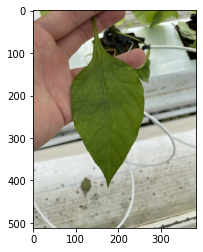

In [156]:
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

### 비교

In [167]:
start_time = time.time()
tr_json_list = glob('/content/train/*/*.json')
# tr_json_list = ['./data' + x[1:] for x in tr_json_list]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.18273544311523438 seconds ---


In [168]:
for i, json_file in enumerate(tqdm(tr_json_list)):
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    if i == 0:
        tr_json_df = pd.json_normalize(json_file_re)
    else:
        tr_json_df = tr_json_df.append(pd.json_normalize(json_file_re))
tr_json_df = tr_json_df.reset_index(drop=True)

100%|██████████| 5767/5767 [00:36<00:00, 156.02it/s]


In [169]:
display(tr_json_df.shape, tr_json_df.head())

(5767, 14)

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류
0,"[{'x': 299.2761863425926, 'h': 206.01903521825...",[],3,1,00,12,0,10124.jpg,20211008,1003,512,682,0,0
1,"[{'x': 92.2509998139881, 'h': 419.019593253968...","[{'x': 95.02964564732143, 'h': 412.35088045634...",3,3,b6,13,1,21984.jpg,20211104,1124,512,384,0,2
2,"[{'x': 13.076917461320466, 'h': 383.228515625,...",[],3,4,00,12,0,23073.jpg,20211006,0940,512,384,0,0
3,"[{'x': 121.6087162078373, 'h': 232.50520833333...","[{'x': 122.14443824404762, 'h': 231.4337642609...",3,5,b7,11,1,64955.jpg,20211202,1301,512,384,0,2
4,"[{'x': 107.65684678819444, 'h': 328.1154203869...","[{'x': 118.62831721230158, 'h': 75.08596850198...",3,3,b8,13,1,62400.jpg,20211103,1800,512,384,0,2


In [170]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'0' : '정상',
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [171]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}")

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')'
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}


### 일소피해 초기/말기 비교
초기랑 말기랑 다른 분포를 보임

In [211]:
tr_json_df[tr_json_df["작물"]=="파프리카(3)"]

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
1,"[{'x': 92.2509998139881, 'h': 419.019593253968...","[{'x': 95.02964564732143, 'h': 412.35088045634...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),21984.jpg,20211104,1124,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
4,"[{'x': 107.65684678819444, 'h': 328.1154203869...","[{'x': 118.62831721230158, 'h': 75.08596850198...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),62400.jpg,20211103,1800,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)
6,"[{'x': 33.25658792162698, 'h': 384.68706597222...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),42261.jpg,20210916,1104,512,384,0,정상(0),3_00_0,NaN
7,"[{'x': 46.21319676959325, 'h': 198.88403707837...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),39765.jpg,20210928,1254,512,242,0,정상(0),3_00_0,NaN
8,"[{'x': 61.940018911210316, 'h': 374.1709449404...","[{'x': 146.48423549107142, 'h': 181.6445157490...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),37415.jpg,20211103,1528,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,"[{'x': 62.27564639136905, 'h': 316.74587673611...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),32112.jpg,20210923,1434,512,384,0,정상(0),3_00_0,NaN
5752,"[{'x': 44.34791201636905, 'h': 401.79182167658...","[{'x': 227.3144066220238, 'h': 106.28607080853...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),15572.jpg,20211103,1001,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)
5753,"[{'x': 44.36288671875, 'h': 282.92753125, 'y':...",[],열매(1),파프리카(3),NaN,착화/과실기(13),정상(0),46124.jpg,20210624,1429,512,384,0,정상(0),3_00_0,NaN
5763,"[{'x': 75.00032552083333, 'h': 287.94766865079...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),57020.jpg,20210924,1148,512,384,0,정상(0),3_00_0,NaN


In [ ]:
# 초기 39656 56269 19271 46143 41575
# 예측못한 놈들 50609 51799
# 중기 28520 37178 58322 55830 32166
# 말기 44688 59855 15788 65435 37691
# 정상 46124 57020

In [212]:
#초기
a9_1_1 = cv2.imread('/content/train/39656/39656.jpg')
a9_1_2 = cv2.imread('/content/train/56269/56269.jpg')
a9_1_3 = cv2.imread('/content/train/19271/19271.jpg')
a9_1_4 = cv2.imread('/content/train/46143/46143.jpg')
a9_1_5 = cv2.imread('/content/train/41575/41575.jpg')
#중기
a9_2_1 = cv2.imread('/content/train/28520/28520.jpg')
a9_2_2 = cv2.imread('/content/train/37178/37178.jpg')
a9_2_3 = cv2.imread('/content/train/58322/58322.jpg')
a9_2_4 = cv2.imread('/content/train/55830/55830.jpg')
a9_2_5 = cv2.imread('/content/train/32166/32166.jpg')
#말기
a9_3_1 = cv2.imread('/content/train/44688/44688.jpg')
a9_3_2 = cv2.imread('/content/train/59855/59855.jpg')
a9_3_3 = cv2.imread('/content/train/15788/15788.jpg')
a9_3_4 = cv2.imread('/content/train/65435/65435.jpg')
a9_3_5 = cv2.imread('/content/train/37691/37691.jpg')
#예측실패
a9_n_1 = cv2.imread('/content/train/50609/50609.jpg')
a9_n_2 = cv2.imread('/content/train/51799/51799.jpg')
#정상
nan_1 = cv2.imread('/content/train/46124/46124.jpg')
nan_2 = cv2.imread('/content/train/57020/57020.jpg')

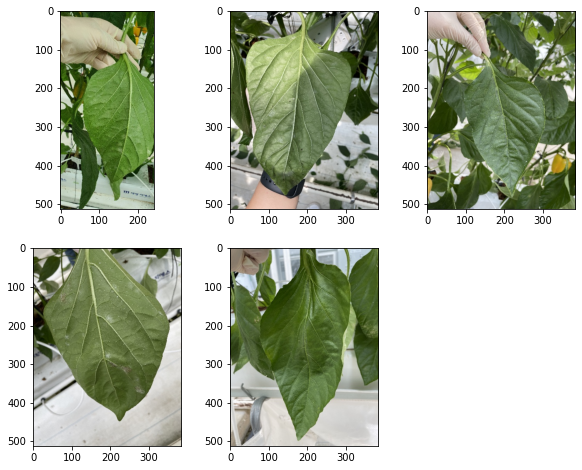

In [224]:
#초기 시각화
plt.figure(figsize=(10,8))

plt.subplot(231)
plt.imshow(cv2.cvtColor(a9_1_1, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.imshow(cv2.cvtColor(a9_1_2, cv2.COLOR_BGR2RGB))
plt.subplot(233)
plt.imshow(cv2.cvtColor(a9_1_3, cv2.COLOR_BGR2RGB))
plt.subplot(234)
plt.imshow(cv2.cvtColor(a9_1_4, cv2.COLOR_BGR2RGB))
plt.subplot(235)
plt.imshow(cv2.cvtColor(a9_1_5, cv2.COLOR_BGR2RGB))

plt.show()


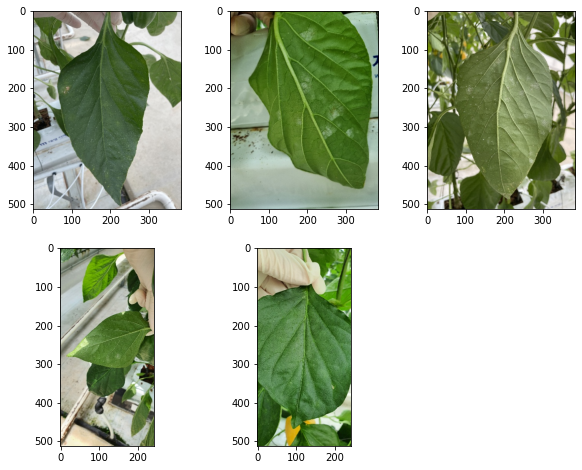

In [225]:
#중기 시각화
plt.figure(figsize=(10,8))

plt.subplot(231)
plt.imshow(cv2.cvtColor(a9_2_1, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.imshow(cv2.cvtColor(a9_2_2, cv2.COLOR_BGR2RGB))
plt.subplot(233)
plt.imshow(cv2.cvtColor(a9_2_3, cv2.COLOR_BGR2RGB))
plt.subplot(234)
plt.imshow(cv2.cvtColor(a9_2_4, cv2.COLOR_BGR2RGB))
plt.subplot(235)
plt.imshow(cv2.cvtColor(a9_2_5, cv2.COLOR_BGR2RGB))

plt.show()

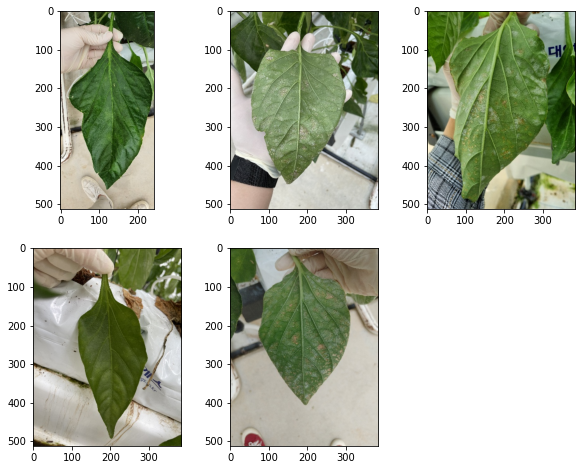

In [226]:
#말기 시각화
plt.figure(figsize=(10,8))

plt.subplot(231)
plt.imshow(cv2.cvtColor(a9_3_1, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.imshow(cv2.cvtColor(a9_3_2, cv2.COLOR_BGR2RGB))
plt.subplot(233)
plt.imshow(cv2.cvtColor(a9_3_3, cv2.COLOR_BGR2RGB))
plt.subplot(234)
plt.imshow(cv2.cvtColor(a9_3_4, cv2.COLOR_BGR2RGB))
plt.subplot(235)
plt.imshow(cv2.cvtColor(a9_3_5, cv2.COLOR_BGR2RGB))

plt.show()

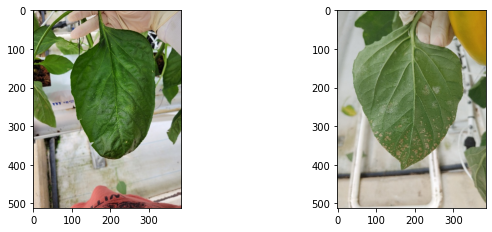

In [227]:
# 예측실패 시각화
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.imshow(cv2.cvtColor(a9_n_1, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.imshow(cv2.cvtColor(a9_n_2, cv2.COLOR_BGR2RGB))

plt.show()

In [215]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]
# 초기인데 중기로 예측한 놈들
a9_n_1_csv = pd.read_csv('/content/train/50609/50609.csv')[csv_features]
a9_n_2_csv = pd.read_csv('/content/train/51799/51799.csv')[csv_features]

# 예측잘한 초기 
a9_1_1_csv = pd.read_csv('/content/train/39656/39656.csv')[csv_features]
# 예측잘한 중기
a9_2_1_csv = pd.read_csv('/content/train/28520/28520.csv')[csv_features]

# 정상
nan_1_csv = pd.read_csv('/content/train/46124/46124.csv')[csv_features]
nan_2_csv = pd.read_csv('/content/train/57020/57020.csv')[csv_features]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

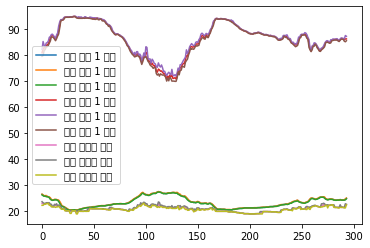

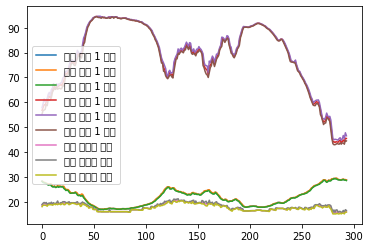

In [233]:
# 초기인데 중기로 잘못 예측한 놈 1
a9_n_1_csv.plot()
# 파프리카 정상
nan_1_csv.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

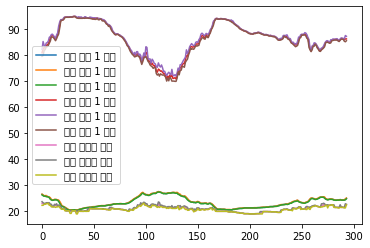

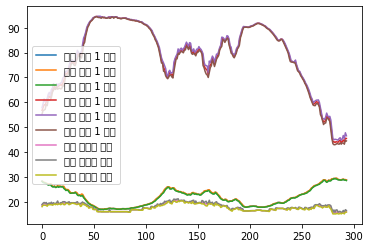

In [229]:
# 초기인데 중기로 잘못 예측한 놈 2
a9_n_2_csv.plot()
# 파프리카 정상
nan_1_csv.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

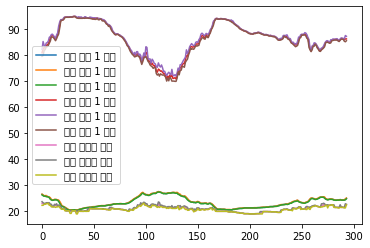

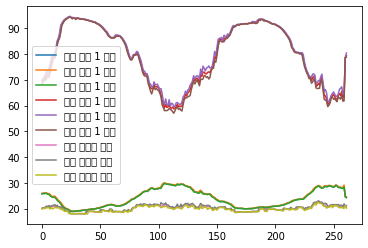

In [232]:
# 잘못예측한놈 1
a9_n_1_csv.plot()
# 초기
a9_1_1_csv.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

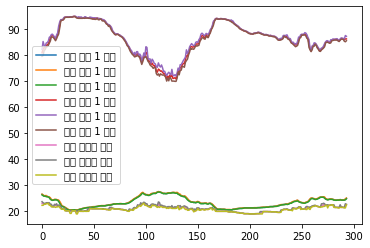

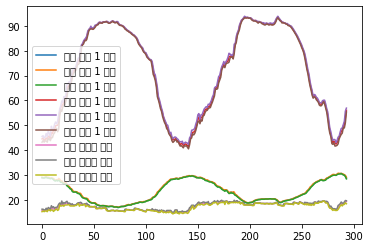

In [231]:
# 잘못예측한놈 1
a9_n_1_csv.plot()
# 중기
a9_2_1_csv.plot()

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/LG/sample_submission.csv')
submission['label'] = preds
submission

In [ ]:
submission.to_csv('/content/drive/MyDrive/LG/submission.csv', index=False)